<div style='font-size: 3em'>SentiLens - Uncover reviews' hidden emotion</div>

__Prepared by:__ Tina Vu</br>
__Date:__ 20231208</br>

Employing aspect-based sentiment analysis (ABSA) to extract valuable feature insights from e-commerce product reviews, thereby empowering consumers to make more informed purchasing decisions and enhancing their overall user experience on the platform.

Utilizing manually annotated reviews for aspect sentiment analysis to extract aspects and predict sentiments from reviews. This enables consumers to obtain a condensed overview of sentiments related to various product features, eliminating the need to delve into an extensive array of reviews. As a result, the decision-making process becomes more streamlined and user-friendly.

__Approach:__

ABSA

__Phase:__
1. Supervised ABSA (What, How)
2. Unsupervised ABSA
3. Add 'Why' into ABSA

<div style='font-size: 2em'>Phase 1 - Aspect Extration</div>

**Table of contents**<a id='toc0_'></a>    
- 1. [Import & prepare dataset](#toc1_)    
  - 1.1. [Import data](#toc1_1_)    
  - 1.2. [Preparing dataset for modelling](#toc1_2_)    
    - 1.2.1. [Unified BIO tagging encode](#toc1_2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from datasets import load_dataset
import pandas as pd
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
# nltk.download()

from sklearn_crfsuite import CRF

/Users/tina.vu/work/fun/brainstation_capstone_env/brainstation_capstone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. <a id='toc1_'></a>[Import & prepare dataset](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Import data](#toc0_)

We will load laptop reviews dataset with aspect term & sentiment annotations.

The dataset comes in two parts:
- train: 3,048 records
- test: 800 records

Each record is a sentence with zero, one or multiple aspect terms. Each aspect term has the following features:
- start character index
- end character index
- sentiment/ polarity (positive or negative)

In [2]:
df_train = pd.read_json('data/laptop/train.json')
df_val = pd.read_json('data/laptop/validate.json')
df_train.shape

(3048, 3)

## 1.2. <a id='toc1_2_'></a>[Preparing dataset for modelling](#toc0_)

The task we are solving is Named Entity Recognition (NER) which is a sequential labeling task, a.k.a we would like to predict whether a token (word) in each sentence is part of an aspect term or not.

In order to prepare the data for NER task, we need to label our tokens. Here, I applied BIO tagging technique, in which a token is tagged 'X' if a token is:
- 'B': begining of an aspect term
- 'I': part of an aspect term but is not the first word
- 'O': not an aspect term

This BIO label technique is more effective in recognizing unigram and n-gram aspect terms comparing to a binary classification.

First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.

In [3]:
df_train.drop_duplicates(subset='text', inplace=True)
df_train.shape

(3036, 3)

In [4]:
df_train.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."


### 1.2.1. <a id='toc1_2_1_'></a>[BIO tagging encode](#toc0_)

Here, I defined a function to encode our sentences' aspects using a BIO tagging technique.

Since aspect terms are denoted using character index in a sentence, I need to figure out the word index in the sentence which is the unit I am going to work with for this task.

In [5]:
def find_word_index(sentence, char_index):
    ''''
    Find word index in a sentence base on the character index in a sentence

    -------------------------------
    Parameters:
    -------------------------------
    sentence: str
      a sentence in string format
      e.g. 'I love pizza'

    char_index: int
      index of the character which can be a beginning, mid, or end of a word that you are searching for

    -------------------------------
    Return:
    -------------------------------
    word_index: int
      index of the word which contains the character of char_index in the sentence
    '''
    words = word_tokenize(sentence)

    # for i, _ in enumerate(words): # Loop through all words in a sentence
    #   total_chars = -1
    #   for w in words[:i+1]:# for each word from beginning of the sentence to word ith
    #     total_chars += len(w) + 1
    #     if char_index <= total_chars:
    #       return i
    # raise Exception(f'char_index({char_index}) > sentence length {len(sentence)} in sentence: "{sentence}"')
       

    return next((i for i, word in enumerate(words) if (char_index - sum(len(w) + 1 for w in words[:i])) < len(word)), len(words) - 1)



__Unified tagging:__
https://arxiv.org/pdf/1811.05082.pdf
BIESO
- B: beginning
- I: inside
- E: ending
- S: single
- O: outside
Sentiment polarity
- NEU
- POS
- NEG

In [6]:
def encode_BIO (x, sentiment_tag=False):
  '''  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: json array
    term: string array
    polarity: string array
    from: integer array
    to: integer array

    For example:
      {
        'term': ['cord', 'battery life'], 
        'polarity': ['neutral', 'positive'], 
        'from': [41, 74],
        'to': [45, 86]
      }
      
  Output:
  - PAIRS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  '''
  pairs=x['aspects']
  # aspects = x['aspects']
  text = x['text']
  text_token = word_tokenize(text)
  # l = len(aspects['term'])

  # for i in range(0,l):
  #   if aspects['term'][i] != '': # Remove empty term
  #     pairs.append(dict({'term': aspects['term'][i]
  #                       ,'polarity':aspects['polarity'][i]
  #                       , 'term_start_char':aspects['from'][i]
  #                       , 'term_end_char':aspects['to'][i]-1
  #                       , 'term_start':find_word_index(text, aspects['from'][i])
  #                       , 'term_end':find_word_index(text, aspects['to'][i]-1)
  #                       }))
  
  aspect_encode = ['O'] * len(text_token)
  
  # text_token = [re.sub('[^\w,\d,\s]', ' ', x.lower()) for x in text_token]
  # pos = pos_tagging(text_token)  
  sentiment_tag_map = {'neutral': '-NEU','conflict':'-NEU', 'positive':'-POS', 'negative':'-NEG', '':''}
  for k in pairs:
    if k['term'] != '':
      term_start = find_word_index(text, int(k['from']))
      term_end = find_word_index(text, int(k['to']))

      polarity = sentiment_tag_map[k['polarity']] if sentiment_tag == True else '' 
      
      aspect_encode = aspect_encode[:term_start] + [f'B{polarity}'] + [f'I{polarity}'] * (term_end - term_start) + aspect_encode[term_end + 1:]
      k['check'] = True if k['term'] == ' '.join(text_token[term_start:term_end]) else False
  # enclosed_aspect_encode = list(zip(text_token, pos, aspect_encode))
  
  return pd.Series([pairs, text_token, aspect_encode])

In [7]:
# Function to convert sentences into features
def word2features(sent, i, window_size=5): 
    word = sent[i]

    _, pos = zip(*nltk.pos_tag(sent))

    window_size = int((window_size - 1)/ 2 if (window_size % 2) == 1 else window_size / 2)
    
    features = {
        'word.lower()': word.lower(), # word
        'word.index()': i,
        'word.reverseindex()': len(sent) - 1 - i, # reverse index - nth word from end of sentence
        'word.pos': pos[i],
        'word.isstopword()': word in en_stop_words,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
        'word.isspecialchar()': re.sub('[^\w,\d,\s]', '', word.lower()) == '', # is punctuation/ special characters
    }
    if i > 0:
        for k in range(1, min(window_size, i)+1):
            prev_word = sent[i - k]
            prev_pos = pos[i - k]
            
            features.update({
                f'-{k}:word.lower()': prev_word.lower(),
                f'-{k}:word.pos': prev_pos,
                f'-{k}:word.isstopword()': prev_word in en_stop_words,
                f'-{k}:word.istitle()': prev_word.istitle(),
                f'-{k}:word.isupper()': prev_word.isupper(),
                f'-{k}:word.isspecialchar()': re.sub('[^\w,\d,\s]', '', prev_word.lower()) == '', # is punctuation/ special characters
            })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        for k in range(1, min(window_size, len(sent) - i - 1)+1):
            next_word = sent[i + k]
            next_pos = pos[i + k]

            features.update({
                f'+{k}:word.lower()': next_word.lower(),
                f'+{k}:word.pos': next_pos,
                f'+{k}:word.isstopword()': next_word in en_stop_words,
                f'+{k}:word.istitle()': next_word.istitle(),
                f'+{k}:word.isupper()': next_word.isupper(),
                f'-{k}:word.isspecialchar()': re.sub('[^\w,\d,\s]', '', next_word.lower()) == '', # is punctuation/ special characters
            })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent, window_size=5):
    return [word2features(sent, i, window_size) for i in range(len(sent))]

In [8]:
df_train[['pairs','text_token','aspect_encode']] = df_train.apply(lambda x: encode_BIO(x, True), axis=1)
df_val[['pairs','text_token','aspect_encode']] = df_val.apply(lambda x: encode_BIO(x, True), axis=1)

In [9]:
df_train.head()

,id,text,aspects,pairs,text_token,aspect_encode
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from...","[{'term': 'cord', 'polarity': 'neutral', 'from...","[I, charge, it, at, night, and, skip, taking, ...","[O, O, O, O, O, O, O, O, O, B-NEU, I-NEU, O, O..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'term': '', 'polarity': '', 'from': 0, 'to':...","[I, bought, a, HP, Pavilion, DV4-1222nr, lapto...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat...","[{'term': 'service center', 'polarity': 'negat...","[The, tech, guy, then, said, the, service, cen...","[O, B-NEU, I-NEU, I-NEU, O, O, B-NEG, I-NEG, I..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'term': '', 'polarity': '', 'from': 0, 'to':...","[I, investigated, netbooks, and, saw, the, Tos...","[O, O, O, O, O, O, O, O, O]"
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'term': '', 'polarity': '', 'from': 0, 'to':...","[The, other, day, I, had, a, presentation, to,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [10]:
X_train = [sent2features(sentence, 5) for sentence in df_train['text_token']]
y_train = df_train['aspect_encode']

X_val = [sent2features(sentence,5) for sentence in df_val['text_token']]
y_val = df_val['aspect_encode']

In [11]:
# test = df_train[:1].copy()
# test[['pairs','text_token','aspect_encode']] = test.apply(lambda x: encode_BIO(x, True), axis=1)
# print(test.iloc[0]['pairs'])
# print(test.iloc[0]['text_token'])
# print(test.iloc[0]['aspect_encode'])

# EDA

1. POS:
  - aspect - sentiment - neither
  - context
2. Word form (compact Xx)
3. Word index
4. Sentiment terms around aspects

# Random forest

- Scale the data
- Add regularization

## Convert X_train to tabular format

In [12]:
X_train_rf = pd.DataFrame()

def features2df(sentence_index, X):
  df = pd.DataFrame(X)
  df['nth_sentence'] = sentence_index
  return df

# Assuming X_train is a list of DataFrames
X_train_rf = pd.concat([features2df(i,X) for i,X in enumerate(X_train)], ignore_index=True)
X_train_rf.head()

,word.lower(),word.index(),word.reverseindex(),word.pos,word.isstopword(),word[-3:],word[-2:],word.isupper(),word.istitle(),word.isdigit(),...,-1:word.isstopword(),-1:word.istitle(),-1:word.isupper(),-2:word.lower(),-2:word.pos,-2:word.isstopword(),-2:word.istitle(),-2:word.isupper(),EOS,nth_sentence
0,i,0,18,PRP,False,I,I,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,charge,1,17,VBP,False,rge,ge,False,False,False,...,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,0
2,it,2,16,PRP,True,it,it,False,False,False,...,False,False,False,i,PRP,False,True,True,NaN,0
3,at,3,15,IN,True,at,at,False,False,False,...,True,False,False,charge,VBP,False,False,False,NaN,0
4,night,4,14,NN,False,ght,ht,False,False,False,...,True,False,False,it,PRP,True,False,False,NaN,0


In [13]:
X_train_rf.replace(True,1, inplace=True)
X_train_rf.replace(False,0, inplace=True)
X_train_rf.fillna(-1, inplace=True)
X_train_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51104 entries, 0 to 51103
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word.lower()             51104 non-null  object 
 1   word.index()             51104 non-null  int64  
 2   word.reverseindex()      51104 non-null  int64  
 3   word.pos                 51104 non-null  object 
 4   word.isstopword()        51104 non-null  int64  
 5   word[-3:]                51104 non-null  object 
 6   word[-2:]                51104 non-null  object 
 7   word.isupper()           51104 non-null  int64  
 8   word.istitle()           51104 non-null  int64  
 9   word.isdigit()           51104 non-null  int64  
 10  word.isspecialchar()     51104 non-null  int64  
 11  BOS                      51104 non-null  float64
 12  +1:word.lower()          51104 non-null  object 
 13  +1:word.pos              51104 non-null  object 
 14  +1:word.isstopword()  

In [14]:
cols = pd.Series(X_train_rf.columns)
drop_cols = cols[cols.str.contains('.*word\.lower\(\)', regex=True)]
drop_cols = pd.concat([drop_cols, cols[cols.str.contains('.*word\[-\d\:]', regex=True)]])
drop_cols

0        word.lower()
12    +1:word.lower()
18    +2:word.lower()
24    -1:word.lower()
29    -2:word.lower()
5           word[-3:]
6           word[-2:]
dtype: object

In [15]:
X_train_rf.drop(columns=drop_cols, inplace=True)
X_train_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51104 entries, 0 to 51103
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word.index()             51104 non-null  int64  
 1   word.reverseindex()      51104 non-null  int64  
 2   word.pos                 51104 non-null  object 
 3   word.isstopword()        51104 non-null  int64  
 4   word.isupper()           51104 non-null  int64  
 5   word.istitle()           51104 non-null  int64  
 6   word.isdigit()           51104 non-null  int64  
 7   word.isspecialchar()     51104 non-null  int64  
 8   BOS                      51104 non-null  float64
 9   +1:word.pos              51104 non-null  object 
 10  +1:word.isstopword()     51104 non-null  float64
 11  +1:word.istitle()        51104 non-null  float64
 12  +1:word.isupper()        51104 non-null  float64
 13  -1:word.isspecialchar()  51104 non-null  int64  
 14  +2:word.pos           

In [16]:
X_train_rf = pd.get_dummies(X_train_rf, drop_first=True)
X_train_rf.shape

(51104, 236)

In [17]:
labels = {"B-POS": 0, "I-POS": 1, "B-NEU": 2, "I-NEU": 3, "B-NEG": 4, "I-NEG": 5, "O":6}
y_train_rf = [labels[y] for sentence in y_train for y in sentence]
y_train_rf[:20]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 6, 6, 6, 6, 6, 0, 1, 1, 6]

In [18]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=X_train_rf.drop(columns='nth_sentence'), y=y_train_rf, cv=5)

In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=y_train_rf)
print(report)

              precision    recall  f1-score   support

           0       0.27      0.09      0.13       986
           1       0.27      0.08      0.12      1151
           2       0.08      0.01      0.02       505
           3       0.13      0.03      0.04       707
           4       0.19      0.05      0.08       863
           5       0.27      0.08      0.12      1124
           6       0.91      0.98      0.94     45768

    accuracy                           0.89     51104
   macro avg       0.30      0.19      0.21     51104
weighted avg       0.83      0.89      0.86     51104



# CRF model

In [20]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

In [21]:
# def post_process_predictions(predictions):
#   for i in range(1, len(predictions)):
#       if predictions[i] == 'I' and predictions[i - 1] == 'O':
#           predictions[i] = 'O'  # Change 'I' to 'O' if not preceded by 'B'
#   return predictions

# Model evaluation

## Sample visualization

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import random
from highlight_text import HighlightText, ax_text, fig_text

def vizualize_samples (sentences, pred_tags, tags = None):

  fig, ax = plt.subplots(figsize=(30,10))
  font = {'family' : 'arial',
          'size'   : 16}
  matplotlib.rc('font', **font)
  final_text = []
  color = []
  pos_element = {"bbox": {"edgecolor": "Green", "facecolor": "#99FF00", "linewidth": 1.5, "pad": 1}} 
  neu_element = {"bbox": {"edgecolor": "Orange", "facecolor": "Yellow", "linewidth": 1.5, "pad": 1.5}} 
  neg_element = {"bbox": {"edgecolor": "Red", "facecolor": "#FF99CC", "linewidth": 1.5, "pad": 1}}
  
  color_map = {'POS': pos_element, 'NEU': neu_element, 'NEG':neg_element}

  for s in range(0, len(sentences)):
    final_text.append('(P) ')
    chunk = []
    next_tag = ''
    
    for w in range(0, len(sentences[s])):
      # print(w)
      word = sentences[s][w]
      tag = pred_tags[s][w]
      # print(tag[2:])  
      if w + 1 < len(sentences[s]):
        next_tag = pred_tags[s][w+1]
      else:
        next_tag = 'O'
      
      # print(word, tag, next_tag)

      if tag == 'O':
        final_text.append(word)
      elif (tag in ['I-POS','I-NEG', 'I-NEU','B-POS','B-NEG', 'B-NEU']):
        chunk.append(word)

      if (next_tag in ['B-POS','B-NEG', 'B-NEU', 'O']) & (len(chunk) > 0):
        final_text.append(f'  <{" ".join(chunk)}>  ')
        color.append(color_map[tag[2:]])
        chunk = []

    if tags is not None:
      final_text.append('\n')
      final_text.append('(A) ')
      for w in range(0, len(sentences[s])):
        # print(w)
        word = sentences[s][w]
        tag = tags[s][w]
        if w + 1 < len(sentences[s]):
          next_tag = tags[s][w+1]
        else:
          next_tag = 'O'
          
        if tag == 'O':
          final_text.append(word)
        elif (tag in ['I-POS','I-NEG', 'I-NEU','B-POS','B-NEG', 'B-NEU']):
          chunk.append(word)

        if (next_tag in ['B-POS','B-NEG', 'B-NEU', 'O']) & (len(chunk) > 0):
          final_text.append(f'  <{" ".join(chunk)}>  ')
          color.append(pos_element)
          chunk = []
  


    

    # if tags is not None:
    #   final_text.append('\n')
    #   final_text.append('(A) ')
    #   for w in range(0, len(sentences[s])):
    #     word = sentences[s][w]
    #     tag = tags[s][w]

    #     if tag !='O':
    #       final_text.append('<{}>'.format(word))
    #       if tag in ['I-POS','I-NEG', 'I-NEU']:
    #         # color.append(color[-1])
    #         color.append(pos_element)
    #       else:
    #         color.append ({'color':random.choice(['blue','green','red','magenta'])})
    #     else:
    #       final_text.append(word)
    
    final_text.append('\n---------------\n')


    HighlightText(x=0, y=1,
                s=' '.join(final_text),
                highlight_textprops=color,
                ax=ax)
                
    plt.axis('off')

285


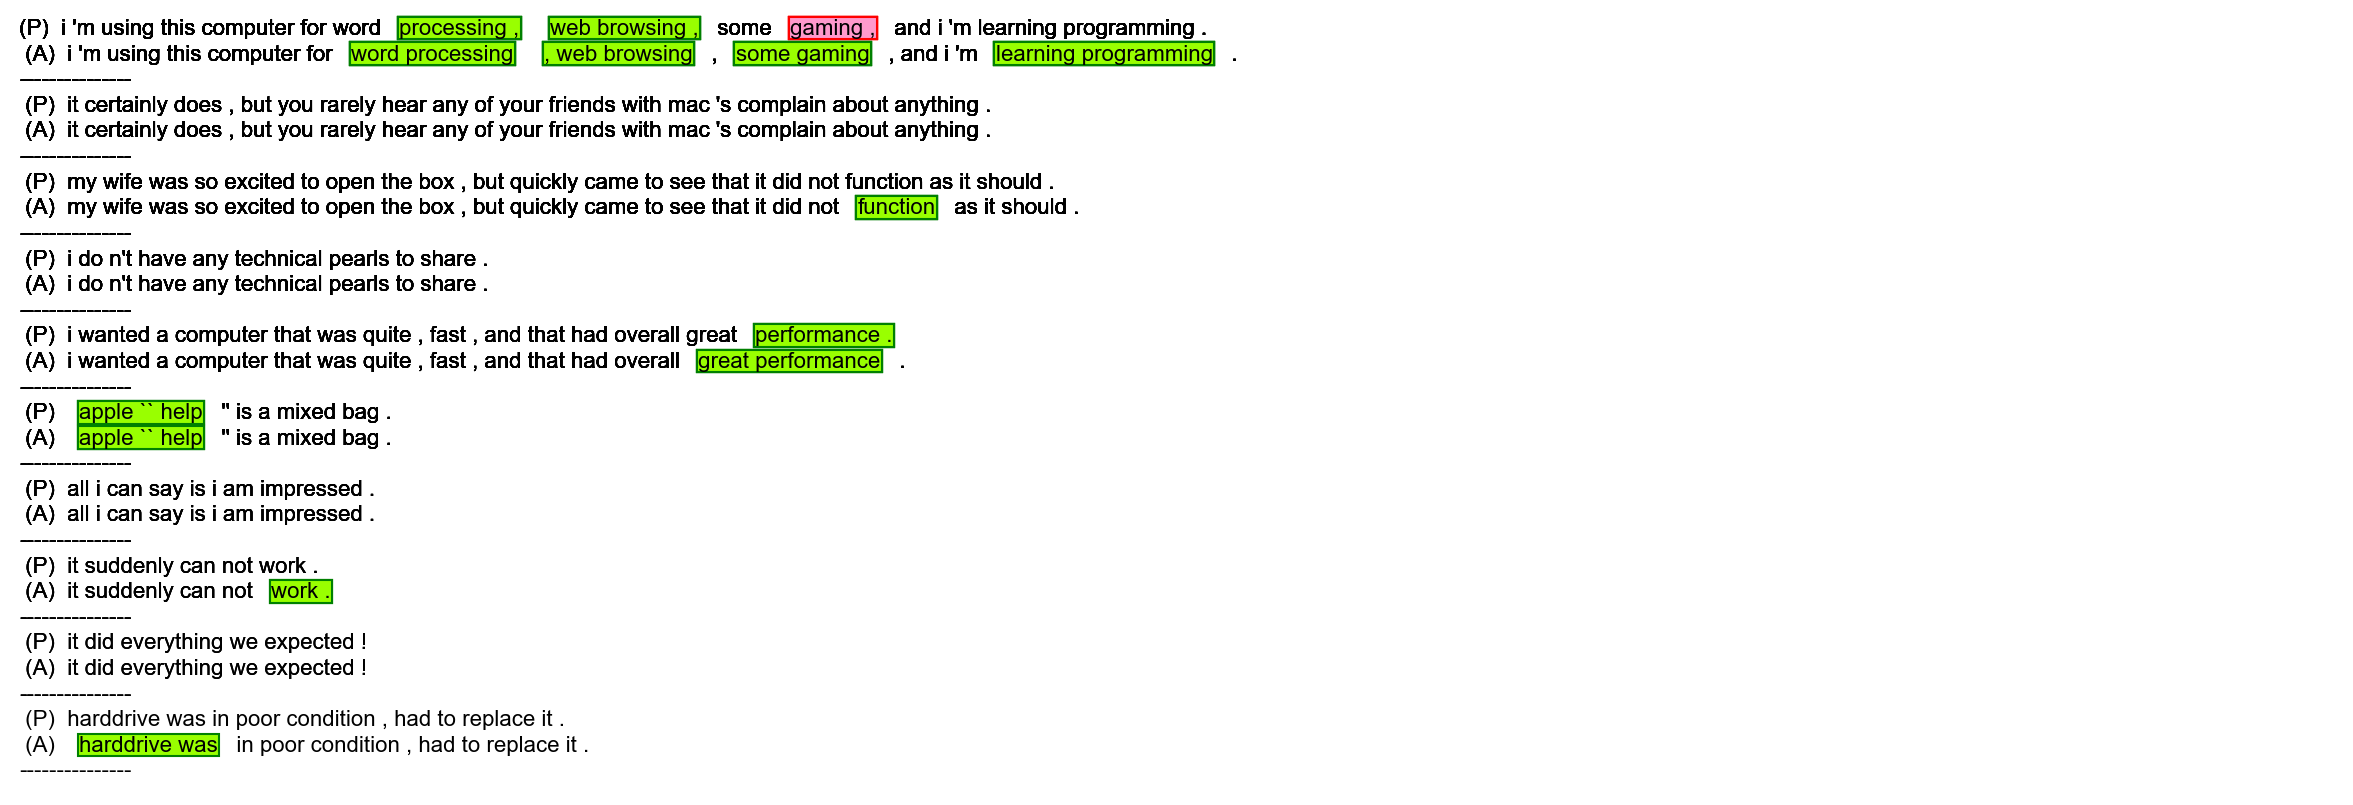

In [23]:
samples = 10
integer = 285 #random.randint(0,500)
tags = y_val[integer:integer+samples].array
pred_tags = crf_model.predict(X_val[integer:integer+samples])
sentences = [[x['word.lower()'] for x in sentence] for sentence in X_val[integer:integer+samples]]

print(integer)
vizualize_samples(sentences, pred_tags, tags)


In [24]:
i = 0
nth = integer + i
print(nth)
print(df_val.iloc[nth]['text'])

print(df_val.iloc[nth]['aspects'])

print(df_val.iloc[nth]['pairs'])

print(pred_tags[i])
print(tags[i])


285
I'm using this computer for word processing, web browsing, some gaming, and I'm learning programming.
[{'term': 'word processing', 'polarity': 'neutral', 'from': '28', 'to': '43', 'check': False}, {'term': 'web browsing', 'polarity': 'neutral', 'from': '45', 'to': '57', 'check': False}, {'term': 'gaming', 'polarity': 'neutral', 'from': '64', 'to': '70', 'check': False}, {'term': 'programming', 'polarity': 'neutral', 'from': '89', 'to': '100', 'check': False}]
[{'term': 'word processing', 'polarity': 'neutral', 'from': '28', 'to': '43', 'check': False}, {'term': 'web browsing', 'polarity': 'neutral', 'from': '45', 'to': '57', 'check': False}, {'term': 'gaming', 'polarity': 'neutral', 'from': '64', 'to': '70', 'check': False}, {'term': 'programming', 'polarity': 'neutral', 'from': '89', 'to': '100', 'check': False}]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-POS', 'I-POS', 'B-POS', 'I-POS', 'I-POS', 'O', 'B-NEG', 'I-NEG', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B-NE

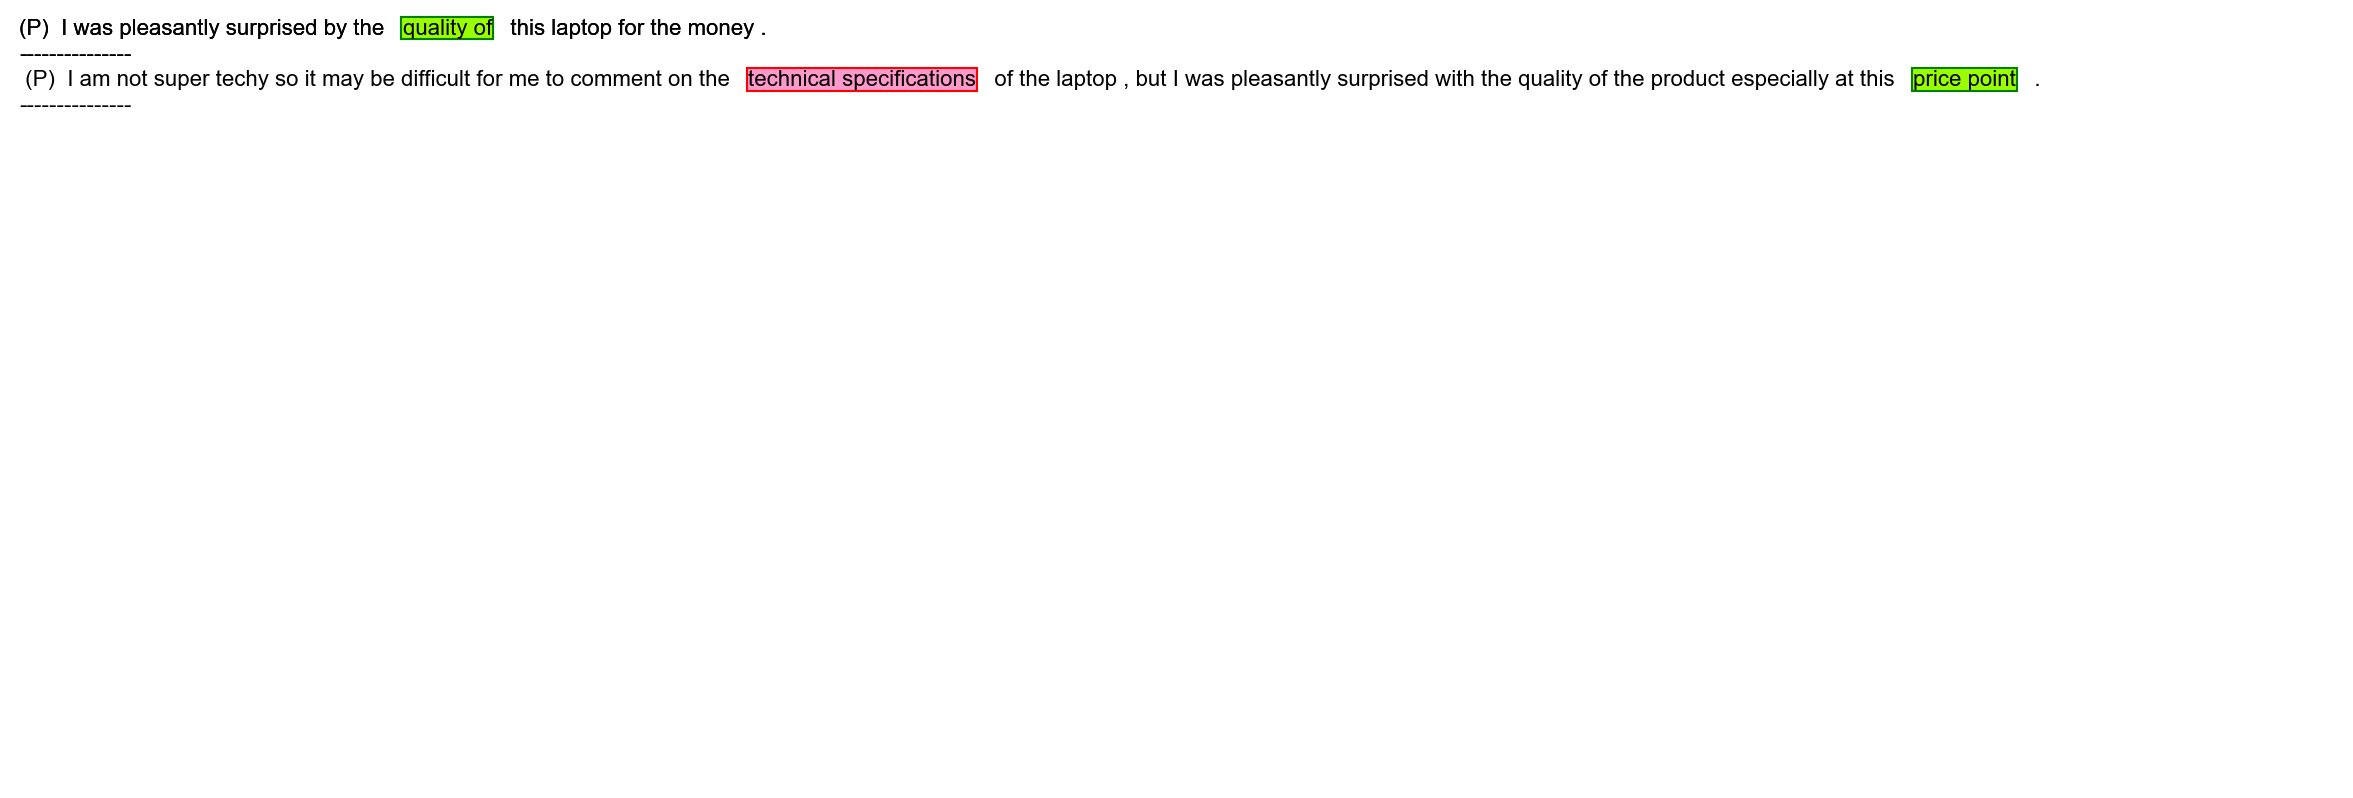

In [25]:
# Test the model with new data
sample = pd.Series(['I was pleasantly surprised by the quality of this laptop for the money. '
            ,'I am not super techy so it may be difficult for me to comment on the technical specifications of the laptop, but I was pleasantly surprised with the quality of the product especially at this price point.'])
sample_text_token = [word_tokenize(sentence) for sentence in sample]
X_sample = [sent2features(sentence, 5) for sentence in sample_text_token]

predicted_labels = crf_model.predict(X_sample)

vizualize_samples(sample_text_token, predicted_labels)


In [26]:
import numpy as np
from sklearn.metrics import classification_report


tags = y_train
pred_tags = crf_model.predict(X_train)


# Create a mapping of labels to indices
labels = {"B-POS": 0, "I-POS": 1, "B-NEU": 2, "I-NEU": 3, "B-NEG": 4, "I-NEG": 5, "O":6}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[x] for x in sum([tag for tag in pred_tags],[])])
truths = np.array([labels[x] for x in sum([tag for tag in tags],[])])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names= ["B-POS", "I-POS", "B-NEU", "I-NEU", "B-NEG", "I-NEG", "O"])
    )

              precision    recall  f1-score   support

       B-POS       0.96      0.92      0.94       986
       I-POS       0.94      0.93      0.93      1151
       B-NEU       0.98      0.90      0.94       505
       I-NEU       0.96      0.95      0.95       707
       B-NEG       0.99      0.93      0.96       863
       I-NEG       0.97      0.95      0.96      1124
           O       0.99      1.00      1.00     45768

    accuracy                           0.99     51104
   macro avg       0.97      0.94      0.95     51104
weighted avg       0.99      0.99      0.99     51104



In [27]:

tags = y_val
pred_tags = crf_model.predict(X_val)



# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[x] for x in sum([tag for tag in pred_tags],[])])
truths = np.array([labels[x] for x in sum([tag for tag in tags],[])])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["B-POS", "I-POS", "B-NEU", "I-NEU", "B-NEG", "I-NEG", "O"])
    )

              precision    recall  f1-score   support

       B-POS       0.52      0.35      0.42       340
       I-POS       0.46      0.29      0.36       422
       B-NEU       0.33      0.10      0.16       185
       I-NEU       0.39      0.11      0.17       318
       B-NEG       0.23      0.20      0.22       128
       I-NEG       0.20      0.18      0.19       186
           O       0.93      0.99      0.96     10230

    accuracy                           0.88     11809
   macro avg       0.44      0.32      0.35     11809
weighted avg       0.86      0.88      0.86     11809



# Next steps
- Add more features:
  - head words
  - Google Word2Vec cluster_id
  - Stemming / Lemming
  - word index from beggining & ending of the sentence
- Employ pre-trained word embeddings
- Re-train model using rule-based aspect term extraction on larger dataset